In [ ]:
!pip install numpy==1.26.4 --upgrade --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:

!pip install torch==2.1.0 torchvision torchaudio
!pip install torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cpu.html


  Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl.m

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
import matplotlib.pyplot as plt

# ✅ Baseline GraphSAGE
class GS(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c, num_layers):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_c, hid_c))
        for _ in range(num_layers-2):
            self.convs.append(SAGEConv(hid_c, hid_c))
        self.convs.append(SAGEConv(hid_c, out_c))
    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs)-1:
                x = F.relu(x)
        return x

# ✅ GDN 모델
class GDN(torch.nn.Module):
    def __init__(self, in_c, hid_c, out_c, num_layers, deltas=None):
        super().__init__()
        if deltas is None:
            self.deltas = [1.0 / (2 ** k) for k in range(num_layers)]
        else:
            assert len(deltas) == num_layers
            self.deltas = deltas
        self.proj = torch.nn.Linear(in_c, hid_c)
        self.convs = torch.nn.ModuleList([SAGEConv(hid_c, hid_c) for _ in range(num_layers)])
        self.out_head = torch.nn.Linear(hid_c * 2, out_c)

    def quantize(self, h, delta):
        b = (torch.rand_like(h) - 0.5) * delta
        return torch.floor((h + b) / delta) * delta - b

    def forward(self, x, edge_index):
        h0 = self.proj(x)
        h = h0
        for k, conv in enumerate(self.convs):
            Δ = self.deltas[k]
            h_q = self.quantize(h, Δ)
            eps = torch.randn_like(h_q) * 0.01
            h = conv(h_q, edge_index) + eps
            h = F.relu(h)
        return self.out_head(torch.cat([h0, h], dim=-1))

In [ ]:
# 학습 및 평가 함수 정의
def train_and_evaluate(model, device, train_loader, val_loader,
                       epochs=100, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # 학습
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
            loss.backward()
            optimizer.step()
    # 평가
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            preds = out.argmax(dim=1)
            correct += (preds[batch.val_mask] == batch.y[batch.val_mask]).sum().item()
            total += batch.val_mask.sum().item()
    return correct / total

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_mean_cosine_similarity(embeddings, mask=None):
    """
    주어진 임베딩 간 평균 cosine similarity 계산
    - embeddings: [N, D]
    - mask: 계산에 포함할 노드 인덱스 (예: val_mask)
    """
    if mask is not None:
        embeddings = embeddings[mask]
    sim_matrix = cosine_similarity(embeddings.cpu().numpy())
    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    return upper_triangle.mean()



=== Layers: 1 ===
GS (baseline): 0.7760
GDN default: 0.5580
GDN [0.1]*n: 0.5920
GDN [0.05]*n: 0.6080
GDN decay: 0.6140

=== Layers: 4 ===
GS (baseline): 0.7700
GDN default: 0.5380
GDN [0.1]*n: 0.5320
GDN [0.05]*n: 0.5360
GDN decay: 0.5340

=== Layers: 8 ===
GS (baseline): 0.6600
GDN default: 0.5080
GDN [0.1]*n: 0.5040
GDN [0.05]*n: 0.4900
GDN decay: 0.5060

=== Layers: 16 ===
GS (baseline): 0.4040
GDN default: 0.4740
GDN [0.1]*n: 0.5180
GDN [0.05]*n: 0.4900
GDN decay: 0.5000


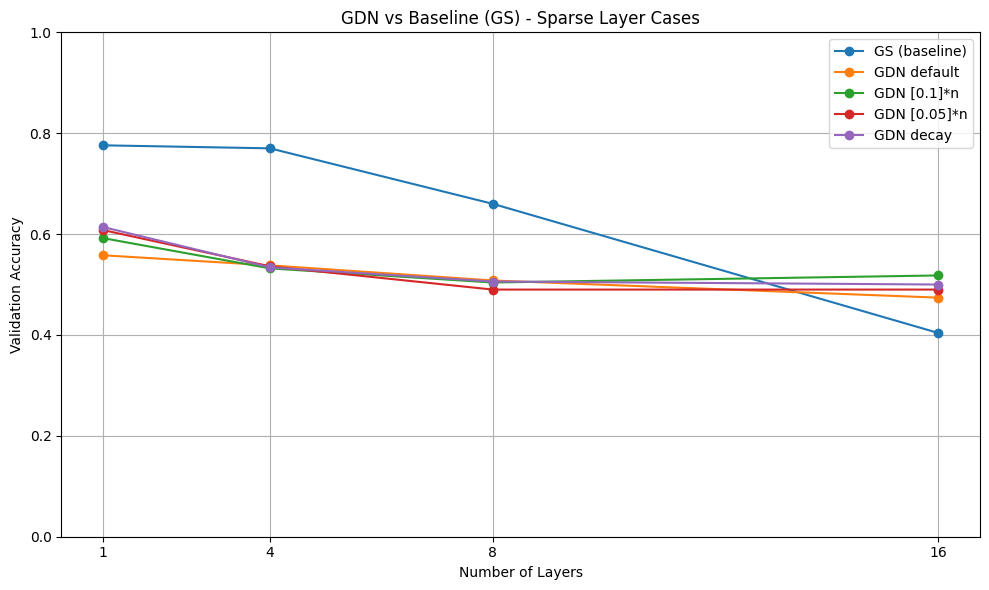

In [ ]:

def get_schedules(num_layers):
    return {
        "GS (baseline)": "baseline",
        "GDN default": None,
        "GDN [0.1]*n": [0.1]*num_layers,
        "GDN [0.05]*n": [0.05]*num_layers,
        "GDN decay": [0.2 / (2**i) for i in range(num_layers)],
    }

layers = [1, 4, 8, 16]  # 순서 보장되는 리스트

all_results = {}
for num_layers in layers:
    schedules = get_schedules(num_layers)
    results = {}
    print(f"\n=== Layers: {num_layers} ===")
    for name, config in schedules.items():
        if config == "baseline":
            model = GS(dataset.num_node_features, 64, dataset.num_classes, num_layers)
        else:
            model = GDN(dataset.num_node_features, 64, dataset.num_classes, num_layers, deltas=config)
        acc = train_and_evaluate(model, device, train_loader, val_loader)
        results[name] = acc
        print(f"{name}: {acc:.4f}")
    all_results[num_layers] = results

# 시각화
plt.figure(figsize=(10, 6))
for label in list(all_results[layers[0]].keys()):
    accs = [all_results[n][label] for n in layers]
    plt.plot(layers, accs, marker='o', label=label)

plt.xlabel("Number of Layers")
plt.ylabel("Validation Accuracy")
plt.title("GDN vs Baseline (GS) - Sparse Layer Cases")
plt.xticks(layers)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
